# COMS3007 - Machine Learning - Inference Coursework

## Setup

For all of the questions in this coursework we used the following Python packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread

Several functions were used to add noise and setup the input images:

In [11]:
def add_gaussian_noise(im,prop,varSigma):
    ########################################################################################
    # add_gaussian_noise - Created image with addition of Gaussina noise
    #   Inputs:
    #       im -> input image
    #       prop -> proportion of pixels to have noise added
    #       varSigma ->
    #   Outputs:
    #      im2 -> noisy image
    ########################################################################################
    N = int(np.round(np.prod(im.shape)*prop))

    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2 = np.float64(im2)
    im2[index] += e[index]

    return im2

def add_saltnpeppar_noise(im,prop):
    ########################################################################################
    # add_saltnpeppar_noise - Created image with addition of salt and pepper noise (flipped pixels)
    #   Inputs:
    #       im -> input image
    #       prop -> proportion of pixels to have noise added
    #   Outputs:
    #      im2 -> noisy image
    ########################################################################################
    N = int(np.round(np.prod(im.shape)*prop))

    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]

    return im2

def setup_image(img, prop, varSigma, level):
    ########################################################################################
    # setup_image - Creates different noisy images and sets noisy and latent images
    #   Inputs:
    #       img -> input image
    #       prop -> proportion of pixels to have noise added
    #       varSigma -> variance of gaussian noise
    #       level -> level of noise (gaussian, saltnpepper, both)
    #   Outputs:
    #      orgImg -> original grayscale image
    #      im2 -> gaussian noise image
    #      im3 -> salnpepper noise image
    #      im4 -> gaussian and slatnpepper noise image
    #      yImg -> noisy image
    #      xImg -> latent image
    ########################################################################################
    # read image and set values to +1 -1
    orgImg = imread(img)  # original image
    orgImg = np.asarray(orgImg, int)
    orgImg[orgImg < np.mean(orgImg)] = -1
    orgImg[orgImg >= np.mean(orgImg)] = 1

    # add noise to original image
    im2 = add_gaussian_noise(orgImg, prop, varSigma)  # gaussian noise
    im3 = add_saltnpeppar_noise(orgImg, prop)  # salt and pepper noise
    im4 = add_saltnpeppar_noise(im2, prop)  # gaussian + salt and pepper noise

    # set latent and noisy images
    if level == 1:  # gaussian noise only
        yImg = np.array(im2)  # noisy image
    elif level == 2:  # salt and pepper noise only
        yImg = np.array(im3)  # noisy image
    elif level == 3:  # both gaussian + salt and pepper noise
        yImg = np.array(im4)  # noisy image
    xImg = yImg  # latent image
    print(xImg.max())
    print(xImg.min())
    print(yImg.max())
    print(yImg.min())
    print(orgImg.max())
    print(orgImg.min())
    
    return orgImg, im2, im3, im4, yImg, xImg

In [12]:
setup_image("../input-images/pug-glasses.jpg", 0.2, 0.2, 3)

2.4705542868491177
-1.646332823161297
2.4705542868491177
-1.646332823161297
1
-1


/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]),
 array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 0.93270407, 1.        , ..., 1.18403334, 1.        ,
         1.        ],
        ...,
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [1.        , 0.73663964, 1.        , ..., 1.        , 1.        ,
         1.0744752 ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ]]),
 array([[1, 1, 1, ..., 1, 0, 1],
        [0, 1, 0, ..., 1, 0, 0],
        [0, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 0, 1, ..., 1, 1, 1],
        [1, 1, 0, ..., 0, 1, 1],
        [1, 0, 1, 

Some other functions were used throughout the questions:

In [3]:
def neighbours(i,j,M,N,size=4):
    ########################################################################################
    # neighbours - Finds the neighbours of a node
    #   Inputs:
    #       i -> x position
    #       j -> y position
    #       M -> size of image in X
    #       N -> size of image in Y
    #       size -> 4 doesn't include diagonals, 8 does include diagonals
    #   Outputs:
    #       n -> array containing coordinates of neighbours
    ########################################################################################
    if size==4:
        if (i==0 and j==0):
             n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
             n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
             n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
             n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
             n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
             n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
             n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
             n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
             n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n

    if size==8:
        if (i==0 and j==0):
             n=[(0,1), (1,0), (1,1)]
        elif i==0 and j==N-1:
             n=[(0,N-2), (1,N-1), (1,N-2)]
        elif i==M-1 and j==0:
             n=[(M-1,1), (M-2,0), (M-2,1)]
        elif i==M-1 and j==N-1:
             n=[(M-1,N-2), (M-2,N-1), (M-2,N-2)]
        elif i==0:
             n=[(0,j-1), (0,j+1), (1,j), (1,j+1), (1,j-1)]
        elif i==M-1:
             n=[(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif j==0:
             n=[(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif j==N-1:
             n=[(i-1,N-1), (i+1,N-1), (i,N-2), (i-1,N-2), (i+1,N-2)]
        else:
             n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i-1,j+1), (i+1,j-1), (i+1,j+1)]

        return n

def energy(noisyImg,latentImg,x,y,consts):
    ########################################################################################
    # energy - Calculates energy function
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       x -> x position
    #       y -> y position
    #       consts -> energy function constants [h,beta,n]
    #   Outputs:
    #       e -> energy of current state
    ########################################################################################
    e = consts[0]*latentImg[x,y] # h*sumXi
#     e += -consts[2]*latentImg[x,y]*noisyImg[x,y] # -n*sumXiYi
    e += -consts[2]*((2*noisyImg[x,y]-1)*latentImg[x,y]) # -n*sumXiYi

    neighbour = neighbours(x, y, latentImg.shape[0], latentImg.shape[1], size=8)

    for ii in range(len(neighbour)):
        e += -consts[1]*latentImg[x,y]*latentImg[neighbour[ii]]

    return e

def convergence_rate(xImg,orgImg):
    ########################################################################################
    # convergence_rate - Calculates the percentage of pixels that are correct in the de-noised image
    #   Inputs:
    #       xImg -> latent image
    #       orgImg -> original image
    #   Outputs:
    #       convergence_rate -> percentage of pixels in xImg that are the same as in orgImg
    ########################################################################################
    convergence_rate = float(np.sum(xImg == orgImg)) / orgImg.size * 100.00
    return convergence_rate

def final_plot(orgImg, im2, im3, im4,xImg, level):
    ########################################################################################
    # final_plot - Plot original image, noisy image and de-noised image
    #   Inputs:
    #       orgImg -> original image
    #       im2 -> gaussian noise image
    #       im3 -> salt n pepper noise image
    #       im4 -> both gaussian and salt n pepper noise image
    #       xImg -> latent image
    #       level -> level of noise (guassian, saltnpepper, both)
    #   Outputs:
    #       plots original, noisy and de-noised image
    ########################################################################################
    if level == 1:
        noisy_im = im2
    if level == 2:
        noisy_im = im3
    if level == 3:
        noisy_im = im4
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(orgImg,cmap='gray')
    axarr[0].set_title('Original Image')
    axarr[1].imshow(noisy_im,cmap='gray')
    axarr[1].set_title('Noisy Image')
    axarr[2].imshow(xImg,cmap='gray')
    axarr[2].set_title('De-noised Image')
    plt.show()

The convergence_rate function calculates the percentage of pixels in the de-noised image that are the same as the original image; this acts as a good quantitative measure of algorithm performance.

## Question 1 - Iterative Conditional Models (ICM)

The functions to implement ICM are as follows:

In [4]:
def totalEnergy(noisyImg,latentImg,consts):
    ########################################################################################
    # totalEnergy - Calculates total energy for whole image
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       consts -> energy function constants [h,beta,n]
    #   Outputs:
    #       totalE -> total energy of image in current state
    ########################################################################################
    totalE = 0

    for i in range(latentImg.shape[0]):
        for j in range(latentImg.shape[1]):
            totalE += energy(noisyImg,latentImg,i,j,consts)

    return totalE

def icm(image,noise,consts,plot_all_flag=0):
    ########################################################################################
    # icm - Calculates best value of pixel for current state using ICM algorithm
    #   Inputs:
    #       image -> noisy image
    #       noise -> [prop, varSigma, level -> proportion of pixels to apply noise, variance of gaussian noise, type of noise (1 - gaussian, 2 - salt and pepper, 3 - both)
    #       consts -> energy function constants [h,beta,n]
    #       plot_all_flag -> 1 = plot each iteration, 0 = don't plot each iteration
    #   Outputs:
    #       plot of de-noised image
    ########################################################################################
    # setup image
    orgImg, im2, im3, im4, yImg, xImg = setup_image(image, noise[0], noise[1], noise[2])

    # calculate total energy of noisy image for convergence
    totalE = totalEnergy(yImg, xImg, consts)
    currentE = totalE

    print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")

    for i in range(T):
        for x in range(xImg.shape[0]):
            for y in range(xImg.shape[1]):

                # energy for convergence
                orgEnergy = energy(yImg, xImg, x, y, consts)
                diffEnergy = totalE - orgEnergy

                testLatentImg1 = np.copy(xImg)
                testLatentImg2 = np.copy(xImg)

                testLatentImg1[x, y] = -1
                testLatentImg2[x, y] = 1

                tstEnergy1 = energy(yImg, testLatentImg1, x, y, consts)
                tstEnergy2 = energy(yImg, testLatentImg2, x, y, consts)

                if tstEnergy1 < tstEnergy2:
                    xImg = testLatentImg1
                    totalE = diffEnergy + tstEnergy1
                elif tstEnergy2 < tstEnergy1:
                    xImg = testLatentImg2
                    totalE = diffEnergy + tstEnergy2

        if plot_all_flag == 1:
            plotICM(xImg, i)
        # break loop if energy hasn't been reduced since previous iteration
        if totalE == currentE:
            print("converged")
            break
        currentE = totalE
        print("Iteration: ", i + 1)
        # print("Total energy: ", totalE)
        print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")

    # Plot original image, noisy image and de-noised image
    final_plot(orgImg, im2, im3, im4, xImg, noise[2])
    
def plotICM(latentImg,i):
    ########################################################################################
    # plotICM - Plots de-noised image 
    #   Inputs:
    #       latentImg -> latent image
    #       i -> number of iterations
    #   Outputs:
    #       plots and saves input image
    ########################################################################################
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.imshow(latentImg, cmap='gray')
    ax.set_title('De-noised Image (%d iterations)' % (i+1), fontsize=16)
#     f.savefig('icm%diterations.png' % i)
    # plt.show()
    return

### Running ICM on a noisy image with 20% of pixels affected by salt and pepper noise and Gaussian noise with variance 0.1

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  64.02 %
Iteration:  1
Percent of pixels correct:  95.26 %
Iteration:  2
Percent of pixels correct:  96.16 %
Iteration:  3
Percent of pixels correct:  96.11 %
Iteration:  4
Percent of pixels correct:  96.03 %
Iteration:  5
Percent of pixels correct:  95.96 %
Iteration:  6
Percent of pixels correct:  95.94 %
Iteration:  7
Percent of pixels correct:  95.93 %
Iteration:  8
Percent of pixels correct:  95.93 %
Iteration:  9
Percent of pixels correct:  95.93 %
converged


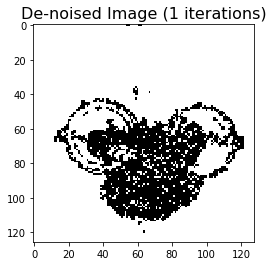

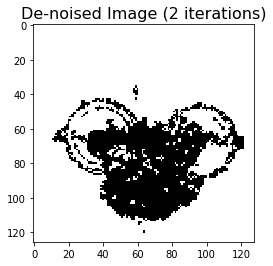

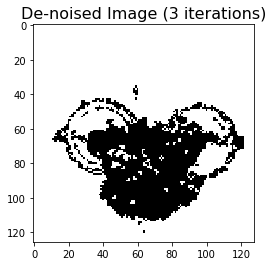

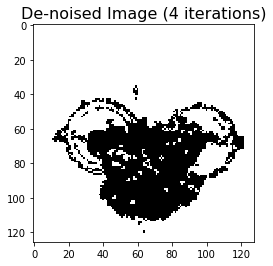

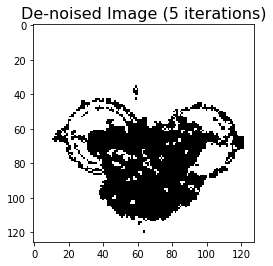

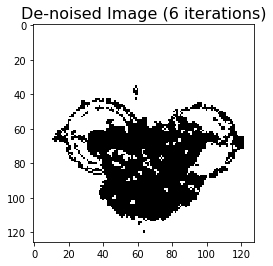

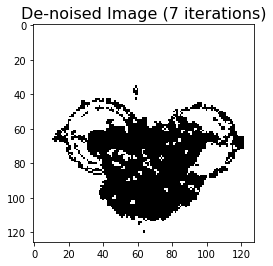

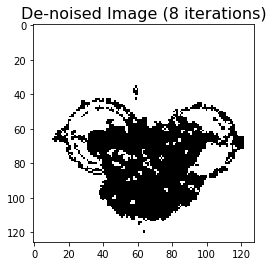

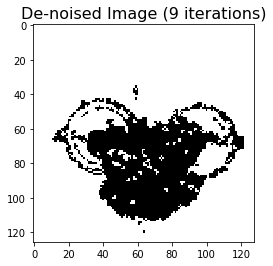

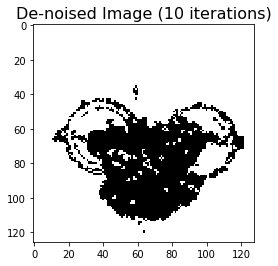

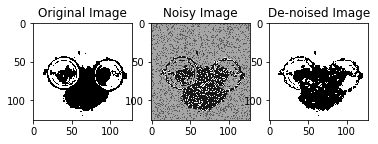

In [5]:
# max number of iterations
T = 20 
plot_all_flag = 1

#  set noise parameters
noise = [0.2, 0.1, 3] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run ICM
icm('pug-glasses.jpg',noise,consts,plot_all_flag)

### Running ICM on a noisy image with 100% of pixels affected by Gaussian noise with variance 0.1

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  0.01 %
Iteration:  1
Percent of pixels correct:  99.06 %
Iteration:  2
Percent of pixels correct:  98.82 %
Iteration:  3
Percent of pixels correct:  98.69 %
Iteration:  4
Percent of pixels correct:  98.64 %
Iteration:  5
Percent of pixels correct:  98.59 %
Iteration:  6
Percent of pixels correct:  98.55 %
Iteration:  7
Percent of pixels correct:  98.54 %
Iteration:  8
Percent of pixels correct:  98.52 %
Iteration:  9
Percent of pixels correct:  98.51 %
Iteration:  10
Percent of pixels correct:  98.5 %
Iteration:  11
Percent of pixels correct:  98.49 %
Iteration:  12
Percent of pixels correct:  98.47 %
Iteration:  13
Percent of pixels correct:  98.46 %
Iteration:  14
Percent of pixels correct:  98.44 %
Iteration:  15
Percent of pixels correct:  98.43 %
Iteration:  16
Percent of pixels correct:  98.41 %
Iteration:  17
Percent of pixels correct:  98.4 %
Iteration:  18
Percent of pixels correct:  98.39 %
converged


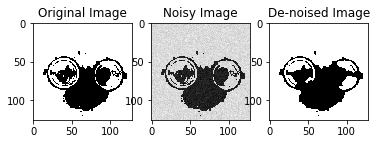

In [6]:
# max number of iterations
T = 20 

#  set noise parameters
noise = [1.0, 0.1, 1] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run ICM
icm('pug-glasses.jpg',noise,consts)

### Running ICM on a noisy image with 100% of pixels affected by Gaussian noise with variance 3.2

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  0.01 %
Iteration:  1
Percent of pixels correct:  69.25 %
Iteration:  2
Percent of pixels correct:  64.35 %
Iteration:  3
Percent of pixels correct:  63.28 %
Iteration:  4
Percent of pixels correct:  63.14 %
Iteration:  5
Percent of pixels correct:  63.11 %
Iteration:  6
Percent of pixels correct:  63.11 %
converged


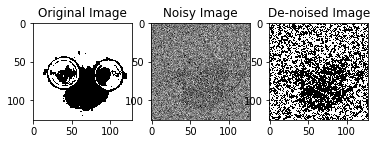

In [7]:
# max number of iterations
T = 20 

#  set noise parameters
noise = [1.0, 3.2, 1] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run ICM
icm('pug-glasses.jpg',noise,consts)

### Running ICM on a noisy image with 50% of pixels affected by Gaussian noise with variance 3.2

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  50.01 %
Iteration:  1
Percent of pixels correct:  83.81 %
Iteration:  2
Percent of pixels correct:  84.34 %
Iteration:  3
Percent of pixels correct:  84.39 %
Iteration:  4
Percent of pixels correct:  84.33 %
Iteration:  5
Percent of pixels correct:  84.3 %
Iteration:  6
Percent of pixels correct:  84.28 %
Iteration:  7
Percent of pixels correct:  84.26 %
Iteration:  8
Percent of pixels correct:  84.24 %
Iteration:  9
Percent of pixels correct:  84.25 %
Iteration:  10
Percent of pixels correct:  84.24 %
Iteration:  11
Percent of pixels correct:  84.22 %
converged


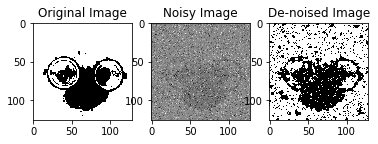

In [8]:
# max number of iterations
T = 20 

#  set noise parameters
noise = [0.5, 3.2, 1] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.7, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run ICM
icm('pug-glasses.jpg',noise,consts)

### Running ICM on a noisy image with 20% of the pixels affected by salt and pepper noise:

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  80.0 %
Iteration:  1
Percent of pixels correct:  95.36 %
Iteration:  2
Percent of pixels correct:  95.86 %
Iteration:  3
Percent of pixels correct:  95.81 %
Iteration:  4
Percent of pixels correct:  95.73 %
Iteration:  5
Percent of pixels correct:  95.64 %
Iteration:  6
Percent of pixels correct:  95.61 %
Iteration:  7
Percent of pixels correct:  95.57 %
Iteration:  8
Percent of pixels correct:  95.5 %
Iteration:  9
Percent of pixels correct:  95.49 %
Iteration:  10
Percent of pixels correct:  95.48 %
Iteration:  11
Percent of pixels correct:  95.47 %
Iteration:  12
Percent of pixels correct:  95.46 %
Iteration:  13
Percent of pixels correct:  95.46 %
Iteration:  14
Percent of pixels correct:  95.44 %
Iteration:  15
Percent of pixels correct:  95.43 %
Iteration:  16
Percent of pixels correct:  95.43 %
Iteration:  17
Percent of pixels correct:  95.43 %
Iteration:  18
Percent of pixels correct:  95.42 %
converged


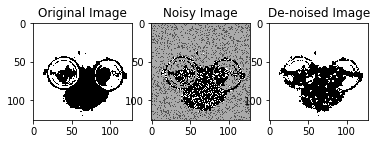

In [9]:
# max number of iterations
T = 20 

#  set noise parameters
noise = [0.2, 0, 2] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run ICM
icm('pug-glasses.jpg',noise,consts)

### Running ICM on a noisy image with 50% of the pixels affected by salt and pepper noise:

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  50.01 %
Iteration:  1
Percent of pixels correct:  84.6 %
Iteration:  2
Percent of pixels correct:  85.44 %
Iteration:  3
Percent of pixels correct:  85.29 %
Iteration:  4
Percent of pixels correct:  85.16 %
Iteration:  5
Percent of pixels correct:  85.04 %
Iteration:  6
Percent of pixels correct:  84.98 %
Iteration:  7
Percent of pixels correct:  84.95 %
Iteration:  8
Percent of pixels correct:  84.94 %
Iteration:  9
Percent of pixels correct:  84.93 %
Iteration:  10
Percent of pixels correct:  84.91 %
converged


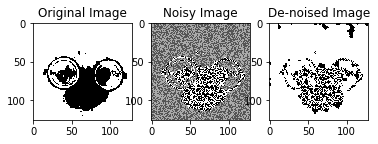

In [10]:
# max number of iterations
T = 20 

#  set noise parameters
noise = [0.5, 0, 2] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run ICM
icm('pug-glasses.jpg',noise,consts)

The ICM algorithm only requires 2-3 passes to obtain good results. A convergence criteria was implemented that converges when the total energy of the image does not decrease after a full pass off the image.

## Questions 2-4 - Gibbs Sampling

The functions to implement Gibbs Sampling are as follows:

In [30]:
def likelihood(y, x, consts):
     return consts[2]*((2*y-1)*x) # likelihood
    
def prior(x_i, x, i, j, consts):
    neighbour = neighbours(i, j, x.shape[0], x.shape[1], size=8)
    prior = 0
    for ii in range(len(neighbour)):
        prior += consts[1]*x_i*x[neighbour[ii]]
    return prior

def gibbs(noisyImg,latentImg,x,y,consts,totalE):
    ########################################################################################
    # gibbs - Calculates best value of pixel for current state using gibbs sampling
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       x -> x position
    #       y -> y position
    #       consts -> energy function constants [h,beta,n]
    #       totalE -> total energy of image
    #   Outputs:
    #       latentImg -> latent image with preferred pixel value
    ########################################################################################
    orgEnergy = energy(noisyImg, latentImg, x, y, consts)
    diffEnergy = totalE - orgEnergy

    testLatentImg1 = np.copy(latentImg)
    testLatentImg2 = np.copy(latentImg)

    testLatentImg1[x, y] = 1
    testLatentImg2[x, y] = -1

    tstEnergy1 = energy(noisyImg, testLatentImg1, x, y, consts)
    tstEnergy2 = energy(noisyImg, testLatentImg2, x, y, consts)
    
    E_0i1 = likelihood(noisyImg[x, y], 1, consts) * prior(1, latentImg, x, y, consts)
    E_0i_1 = likelihood(noisyImg[x, y], -1, consts) * prior(-1, latentImg, x, y, consts)
    
    px1 = px1 / (px1 + px2)
    

#     px1 = np.exp(-tstEnergy1) / (np.exp(-tstEnergy2) + np.exp(-tstEnergy1)) # p(x_i=1 | x_\i,y_i)

    # t = np.random.uniform(0,1)
    t = np.random.uniform(0.4, 0.6)

    if px1 > t:
        latentImg = testLatentImg1
        totalE = diffEnergy + tstEnergy1
    else:
        latentImg = testLatentImg2
        totalE = diffEnergy + tstEnergy2

    return latentImg, totalE

def gibbsMain(image,noise,consts,random_node_flag,plot_all_flag):
    ########################################################################################
    # gibbs - De-noises image using gibbs sampling
    #   Inputs:
    #       image -> noisy image
    #       noise -> [prop, varSigma, level -> proportion of pixels to apply noise, variance of gaussian noise, type of noise (1 - gaussian, 2 - salt and pepper, 3 - both)
    #       consts -> energy function constants [h,beta,n]
    #       random_node_flag -> if random_node_flag=1 then selects random pixel each iteration
    #       plot_all_flag -> if plot_all_flag=1 then plots each iteration
    #   Outputs:
    #       plot of de-noised image
    ########################################################################################
    # setup image
    orgImg, im2, im3, im4, yImg, xImg = setup_image(image, noise[0], noise[1], noise[2])

    # calculate total energy of noisy image
    totalE = totalEnergy(yImg, xImg, consts)
    currentE = totalE

    print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")

    # Perform gibbs sampling with either random or structured cycling through nodes
    if random_node_flag == 1:
        np.random.seed(42)  # fix the random seed to get reproducible results
        N = xImg.shape[0] * xImg.shape[1]  # calculate number of pixels
        for i in range(T):
            for a in range(1, N):
                x = np.random.randint(0, orgImg.shape[0])  # pick random x
                y = np.random.randint(0, orgImg.shape[1])  # pick random y
                xImg, totalE = gibbs(yImg, xImg, x, y, consts, totalE)  # run gibbs sampling

            print("Iteration: ", i + 1)
            print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
            if plot_all_flag == 1:
                plotGibbs(xImg, i + 1)

            # break loop if energy hasn't been reduced since previous iteration
            if totalE == currentE:
                print("converged")
                break
            currentE = totalE
    else:
        for i in range(T):
            for x in range(xImg.shape[0]):
                for y in range(xImg.shape[1]):
                    xImg, totalE = gibbs(yImg, xImg, x, y, consts, totalE)  # run gibbs sampling

            print("Iteration: ", i + 1)
            print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")
            if plot_all_flag == 1:
                plotGibbs(xImg,i+1)

            # break loop if energy hasn't been reduced since previous iteration
            if totalE == currentE:
                print("converged")
                break
            currentE = totalE

    # Plot original image, noisy image and de-noised image
    final_plot(orgImg, im2, im3, im4, xImg, noise[2])
    
def plotGibbs(latentImg,i):
    ########################################################################################
    # plotGibbs - Plots de-noised image
    #   Inputs:
    #       latentImg -> latent image
    #       i -> number of iterations
    #   Outputs:
    #       plots and saves input image
    ########################################################################################
    f = plt.figure()
    ax = f.add_subplot(111)
    ax.imshow(latentImg, cmap='gray')
    ax.set_title('De-noised Image (%d iterations)' % i, fontsize=16)
    # f.savefig('gibbs%diterations.png' % i)
    return

## Question 2 - Gibbs Sampling with pixels picked sequentially

### Gibbs Sampling on a noisy image with 20% of pixels affected by salt and pepper noise and Gaussian noise with variance 0.1

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


Percent of pixels correct:  64.11 %
Iteration:  1
Percent of pixels correct:  48.57 %
Iteration:  2
Percent of pixels correct:  43.58 %
Iteration:  3
Percent of pixels correct:  44.28 %
Iteration:  4
Percent of pixels correct:  43.87 %
Iteration:  5
Percent of pixels correct:  44.09 %
Iteration:  6
Percent of pixels correct:  43.63 %
Iteration:  7
Percent of pixels correct:  44.07 %
Iteration:  8
Percent of pixels correct:  44.4 %
Iteration:  9
Percent of pixels correct:  44.12 %
Iteration:  10
Percent of pixels correct:  44.14 %
Iteration:  11
Percent of pixels correct:  43.57 %
Iteration:  12
Percent of pixels correct:  43.77 %
Iteration:  13
Percent of pixels correct:  44.33 %
Iteration:  14
Percent of pixels correct:  43.62 %
Iteration:  15
Percent of pixels correct:  44.23 %
Iteration:  16
Percent of pixels correct:  43.92 %
Iteration:  17
Percent of pixels correct:  44.33 %
Iteration:  18
Percent of pixels correct:  43.62 %
Iteration:  19
Percent of pixels correct:  44.24 %
Itera

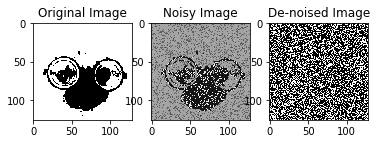

In [31]:
random_node_flag = 0 # random node flag
plot_all_flag = 0 # plot each iteration flag
T = 20 # number of iterations

# set noise parameters
noise = [0.2, 0.1, 3] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run gibbs sampling
gibbsMain('pug-glasses.jpg',noise,consts,random_node_flag,plot_all_flag)

### Gibbs Sampling on a noisy image with 100% of pixels affected by Gaussian noise with variance 0.1

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  0.01 %
Iteration:  1
Percent of pixels correct:  99.12 %
Iteration:  2
Percent of pixels correct:  98.83 %
Iteration:  3
Percent of pixels correct:  98.68 %
Iteration:  4
Percent of pixels correct:  98.62 %
Iteration:  5
Percent of pixels correct:  98.57 %
Iteration:  6
Percent of pixels correct:  98.52 %
Iteration:  7
Percent of pixels correct:  98.51 %
Iteration:  8
Percent of pixels correct:  98.48 %
Iteration:  9
Percent of pixels correct:  98.46 %
Iteration:  10
Percent of pixels correct:  98.46 %
Iteration:  11
Percent of pixels correct:  98.44 %
Iteration:  12
Percent of pixels correct:  98.44 %
Iteration:  13
Percent of pixels correct:  98.41 %
Iteration:  14
Percent of pixels correct:  98.39 %
Iteration:  15
Percent of pixels correct:  98.36 %
Iteration:  16
Percent of pixels correct:  98.36 %
Iteration:  17
Percent of pixels correct:  98.35 %
Iteration:  18
Percent of pixels correct:  98.35 %
Iteration:  19
Percent of pixels correct:  98.34 %
Itera

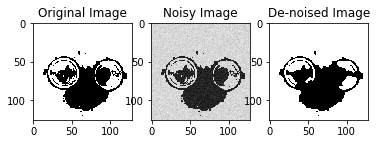

In [13]:
random_node_flag = 0 # random node flag
plot_all_flag = 0 # plot each iteration flag
T = 20 # number of iterations

# set noise parameters
noise = [1.0, 0.1, 1] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run gibbs sampling
gibbsMain('pug-glasses.jpg',noise,consts,random_node_flag,plot_all_flag)

### Gibbs Sampling on a noisy image with 100% of pixels affected by Gaussian noise with variance 3.2

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  0.01 %
Iteration:  1
Percent of pixels correct:  68.55 %
Iteration:  2
Percent of pixels correct:  64.32 %
Iteration:  3
Percent of pixels correct:  63.31 %
Iteration:  4
Percent of pixels correct:  63.14 %
Iteration:  5
Percent of pixels correct:  62.92 %
Iteration:  6
Percent of pixels correct:  62.89 %
Iteration:  7
Percent of pixels correct:  62.86 %
Iteration:  8
Percent of pixels correct:  62.87 %
Iteration:  9
Percent of pixels correct:  62.8 %
Iteration:  10
Percent of pixels correct:  62.79 %
Iteration:  11
Percent of pixels correct:  62.83 %
Iteration:  12
Percent of pixels correct:  62.74 %
Iteration:  13
Percent of pixels correct:  62.84 %
Iteration:  14
Percent of pixels correct:  62.79 %
Iteration:  15
Percent of pixels correct:  62.83 %
Iteration:  16
Percent of pixels correct:  62.74 %
Iteration:  17
Percent of pixels correct:  62.81 %
Iteration:  18
Percent of pixels correct:  62.75 %
Iteration:  19
Percent of pixels correct:  62.8 %
Iterati

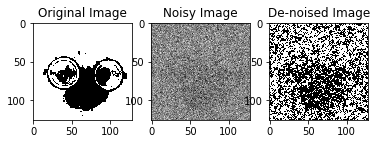

In [14]:
random_node_flag = 0 # random node flag
plot_all_flag = 0 # plot each iteration flag
T = 20 # number of iterations

# set noise parameters
noise = [1.0, 3.2, 1] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run gibbs sampling
gibbsMain('pug-glasses.jpg',noise,consts,random_node_flag,plot_all_flag)

### Gibbs Sampling on a noisy image with 50% of pixels affected by Gaussian noise with variance 3.2

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  50.01 %
Iteration:  1
Percent of pixels correct:  82.45 %
Iteration:  2
Percent of pixels correct:  82.44 %
Iteration:  3
Percent of pixels correct:  82.35 %
Iteration:  4
Percent of pixels correct:  82.3 %
Iteration:  5
Percent of pixels correct:  82.25 %
Iteration:  6
Percent of pixels correct:  82.2 %
Iteration:  7
Percent of pixels correct:  82.22 %
Iteration:  8
Percent of pixels correct:  82.15 %
Iteration:  9
Percent of pixels correct:  82.21 %
Iteration:  10
Percent of pixels correct:  82.22 %
Iteration:  11
Percent of pixels correct:  82.2 %
Iteration:  12
Percent of pixels correct:  82.2 %
Iteration:  13
Percent of pixels correct:  82.25 %
Iteration:  14
Percent of pixels correct:  82.19 %
Iteration:  15
Percent of pixels correct:  82.19 %
Iteration:  16
Percent of pixels correct:  82.2 %
Iteration:  17
Percent of pixels correct:  82.19 %
Iteration:  18
Percent of pixels correct:  82.23 %
Iteration:  19
Percent of pixels correct:  82.2 %
Iteration:

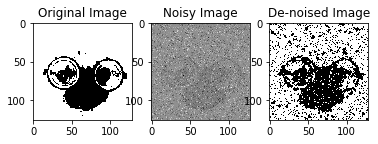

In [15]:
random_node_flag = 0 # random node flag
plot_all_flag = 0 # plot each iteration flag
T = 20 # number of iterations

# set noise parameters
noise = [0.5, 3.2, 1] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run gibbs sampling
gibbsMain('pug-glasses.jpg',noise,consts,random_node_flag,plot_all_flag)

### Gibbs Sampling on a noisy image with 20% of pixels affected by salt and pepper noise

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  80.0 %
Iteration:  1
Percent of pixels correct:  95.32 %
Iteration:  2
Percent of pixels correct:  95.99 %
Iteration:  3
Percent of pixels correct:  95.96 %
Iteration:  4
Percent of pixels correct:  95.87 %
Iteration:  5
Percent of pixels correct:  95.86 %
Iteration:  6
Percent of pixels correct:  95.83 %
Iteration:  7
Percent of pixels correct:  95.83 %
Iteration:  8
Percent of pixels correct:  95.83 %
converged


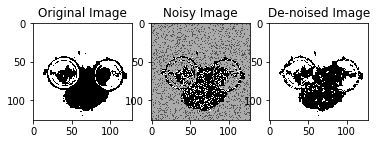

In [16]:
random_node_flag = 0 # random node flag
plot_all_flag = 0 # plot each iteration flag
T = 20 # number of iterations

# set noise parameters
noise = [0.2, 0.0, 2] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run gibbs sampling
gibbsMain('pug-glasses.jpg',noise,consts,random_node_flag,plot_all_flag)

### Gibbs Sampling on a noisy image with 50% of pixels affected by salt and pepper noise

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  50.01 %
Iteration:  1
Percent of pixels correct:  84.31 %
Iteration:  2
Percent of pixels correct:  85.04 %
Iteration:  3
Percent of pixels correct:  84.97 %
Iteration:  4
Percent of pixels correct:  84.86 %
Iteration:  5
Percent of pixels correct:  84.82 %
Iteration:  6
Percent of pixels correct:  84.8 %
Iteration:  7
Percent of pixels correct:  84.77 %
Iteration:  8
Percent of pixels correct:  84.75 %
Iteration:  9
Percent of pixels correct:  84.74 %
Iteration:  10
Percent of pixels correct:  84.72 %
Iteration:  11
Percent of pixels correct:  84.71 %
Iteration:  12
Percent of pixels correct:  84.69 %
Iteration:  13
Percent of pixels correct:  84.69 %
Iteration:  14
Percent of pixels correct:  84.69 %
converged


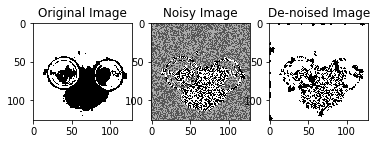

In [17]:
random_node_flag = 0 # random node flag
plot_all_flag = 0 # plot each iteration flag
T = 20 # number of iterations

# set noise parameters
noise = [0.5, 0.0, 2] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run gibbs sampling
gibbsMain('pug-glasses.jpg',noise,consts,random_node_flag,plot_all_flag)

## Question 3 - Gibbs Sampling using randomly ordered pixels

### Gibbs Sampling on a noisy image with 20% of pixels affected by salt and pepper noise and Gaussian Noise with variance 0.1

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  64.15 %
Iteration:  1
Percent of pixels correct:  83.47 %
Iteration:  2
Percent of pixels correct:  90.71 %
Iteration:  3
Percent of pixels correct:  93.74 %
Iteration:  4
Percent of pixels correct:  94.88 %
Iteration:  5
Percent of pixels correct:  95.2 %
Iteration:  6
Percent of pixels correct:  95.33 %
Iteration:  7
Percent of pixels correct:  95.35 %
Iteration:  8
Percent of pixels correct:  95.32 %
Iteration:  9
Percent of pixels correct:  95.3 %
Iteration:  10
Percent of pixels correct:  95.3 %
Iteration:  11
Percent of pixels correct:  95.31 %
Iteration:  12
Percent of pixels correct:  95.28 %
Iteration:  13
Percent of pixels correct:  95.29 %
Iteration:  14
Percent of pixels correct:  95.28 %
Iteration:  15
Percent of pixels correct:  95.28 %
Iteration:  16
Percent of pixels correct:  95.3 %
Iteration:  17
Percent of pixels correct:  95.3 %
Iteration:  18
Percent of pixels correct:  95.31 %
Iteration:  19
Percent of pixels correct:  95.3 %
Iteration:

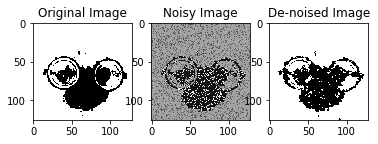

In [18]:
random_node_flag = 1 # random node flag
plot_all_flag = 0 # plot each iteration flag
T = 20 # number of iterations

# set noise parameters
noise = [0.2, 0.1, 3] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run gibbs sampling
gibbsMain('pug-glasses.jpg',noise,consts,random_node_flag,plot_all_flag)

## Question 4 - Gibbs Sampling - does the number of iterations always improve denoising?

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  64.05 %
Iteration:  1
Percent of pixels correct:  95.53 %
Iteration:  2
Percent of pixels correct:  96.08 %
Iteration:  3
Percent of pixels correct:  95.93 %
Iteration:  4
Percent of pixels correct:  95.85 %
Iteration:  5
Percent of pixels correct:  95.87 %
Iteration:  6
Percent of pixels correct:  95.83 %
Iteration:  7
Percent of pixels correct:  95.81 %
Iteration:  8
Percent of pixels correct:  95.8 %
Iteration:  9
Percent of pixels correct:  95.81 %
Iteration:  10
Percent of pixels correct:  95.8 %


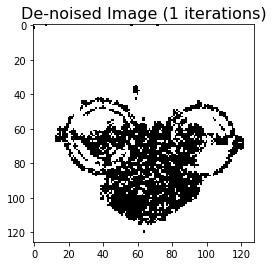

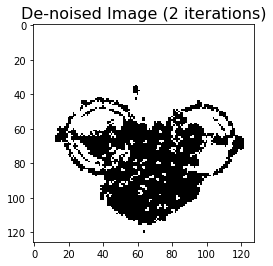

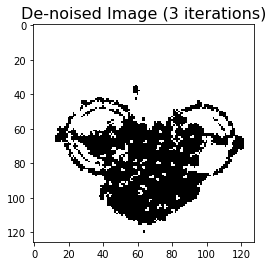

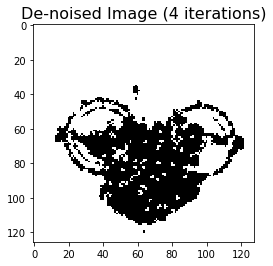

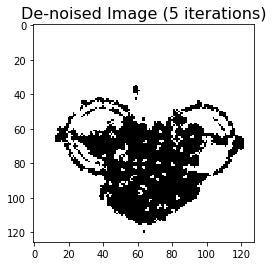

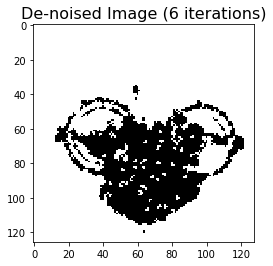

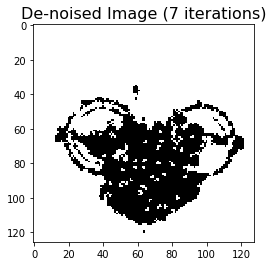

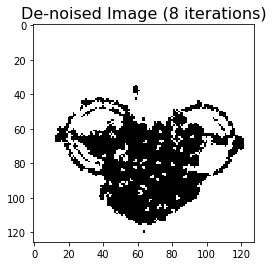

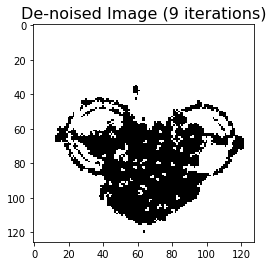

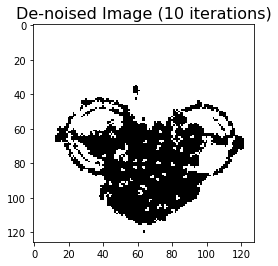

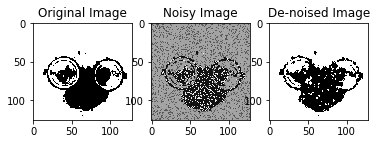

In [19]:
random_node_flag = 0 # random node flag
plot_all_flag = 1 # plot each iteration flag
T = 10 # number of iterations

# set noise parameters
noise = [0.2, 0.1, 3] # [prop, varSigma, level]

# set energy function constants
consts = [0.3,0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run gibbs sampling
gibbsMain('pug-glasses.jpg',noise,consts,random_node_flag,plot_all_flag)

## Questions 6-7 - Variational Bayes

The functions to implement Variational Bayes are as follows:

In [5]:
def varBayes(image,noise,consts,plot_all_flag=0):
    ########################################################################################
    # varBayes -> Calculates best value of pixel for current state using variational Bayes
    #               and updates variational parameter
    #   Inputs:
    #       image -> noisy image
    #       noise -> [prop, varSigma, level -> proportion of pixels to apply noise, variance of gaussian noise, type of noise (1 - gaussian, 2 - salt and pepper, 3 - both)
    #       consts -> energy function constants [h,beta,n]
    #       plot_all_flag -> if plot_all_flag=1 then plots each iteration
    #   Outputs:
    #       plot of de-noised image
    ########################################################################################
    # setup image
    orgImg, im2, im3, im4, yImg, xImg = setup_image(image, noise[0], noise[1], noise[2])

    mu = np.zeros([xImg.shape[0], xImg.shape[1]])  # variational distribution

    # calculate total energy of noisy image
    totalE = totalEnergy(yImg, xImg, consts)
    currentE = totalE

    print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")

    for i in range(T):
        for x in range(xImg.shape[0]):
            for y in range(xImg.shape[1]):

                orgEnergy = energy(yImg, xImg, x, y, consts)
                diffEnergy = totalE - orgEnergy

                # calculate variational parameter for current pixel
                m_i = 0
                neighbour = neighbours(x, y, xImg.shape[0], xImg.shape[1], size=8)
                for ii in range(len(neighbour)):
                    neighbour1 = neighbour[ii]
                    m_i += consts[1] * mu[neighbour1[0], neighbour1[1]]
                a_i = m_i + 1 / 2 * ((consts[0] * 1 - consts[2] * 1 * yImg[x, y]) - (consts[0] * -1 - consts[2] * -1 * yImg[x, y]))  # where Li(xi) = h*sumXi - n*sumXiYi
                mu_i = np.tanh(a_i)

                # update variational parameter matrix
                mu[x, y] = mu_i

                # calculate posterior for pixel i
                q_x = 1 / (1 + np.exp(-2 * a_i))

                # set pixel value in latent image (x) based on posterior
                if q_x < 0.5:
                    xImg[x, y] = 1
                else:
                    xImg[x, y] = -1

                totalE = diffEnergy + energy(yImg, xImg, x, y, consts)

        if plot_all_flag == 1:
            plotVarBayes(xImg, i + 1)

        # break loop if energy hasn't been reduced since previous iteration
        if totalE == currentE:
            print("converged")
            break
        currentE = totalE

        print("Iteration: ", i + 1)
        print("Percent of pixels correct: ", round(convergence_rate(xImg, orgImg), 2), "%")

    #   Plot original image, noisy image and de-noised image
    final_plot(orgImg, im2, im3, im4, xImg, noise[2])

## Question 6 - Variational Bayes for Ising Model

### Variational Bayes on a noisy image with 20% of pixels affected by salt and pepper noise and Gaussian Noise with variance 0.1

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  63.85 %
Iteration:  1
Percent of pixels correct:  94.11 %
Iteration:  2
Percent of pixels correct:  96.53 %
Iteration:  3
Percent of pixels correct:  96.36 %
Iteration:  4
Percent of pixels correct:  96.27 %
Iteration:  5
Percent of pixels correct:  96.24 %
Iteration:  6
Percent of pixels correct:  96.19 %
Iteration:  7
Percent of pixels correct:  96.16 %
Iteration:  8
Percent of pixels correct:  96.14 %
Iteration:  9
Percent of pixels correct:  96.14 %
Iteration:  10
Percent of pixels correct:  96.14 %
Iteration:  11
Percent of pixels correct:  96.14 %
converged


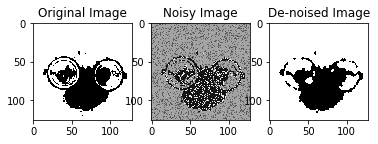

In [7]:
T = 20 # max number of iterations

#  set noise parameters
noise = [0.2, 0.1, 3] # [prop, varSigma, level]

# set energy function constants
consts = [0.3, 0.5, 1.5] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run variational Bayes
varBayes('../input-images/pug-glasses.jpg',noise,consts,plot_all_flag=0)

### Variational Bayes on a noisy image with 100% of pixels affected by Gaussian Noise with variance 0.1

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  0.01 %
Iteration:  1
Percent of pixels correct:  98.2 %
Iteration:  2
Percent of pixels correct:  97.56 %
Iteration:  3
Percent of pixels correct:  97.35 %
Iteration:  4
Percent of pixels correct:  97.27 %
Iteration:  5
Percent of pixels correct:  97.23 %
Iteration:  6
Percent of pixels correct:  97.22 %
Iteration:  7
Percent of pixels correct:  97.19 %
Iteration:  8
Percent of pixels correct:  97.18 %
Iteration:  9
Percent of pixels correct:  97.17 %
Iteration:  10
Percent of pixels correct:  97.17 %
Iteration:  11
Percent of pixels correct:  97.16 %
Iteration:  12
Percent of pixels correct:  97.15 %
converged


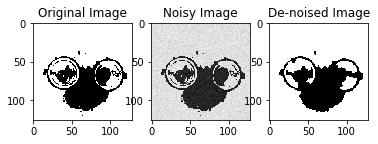

In [22]:
T = 20 # max number of iterations

#  set noise parameters
noise = [1.0, 0.1, 1] # [prop, varSigma, level]

# set energy function constants
consts = [0.3, 0.5, 1.5] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run variational Bayes
varBayes('pug-glasses.jpg',noise,consts,plot_all_flag=0)

### Variational Bayes on a noisy image with 100% of pixels affected by Gaussian Noise with variance 3.2

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  0.01 %
Iteration:  1
Percent of pixels correct:  65.28 %
Iteration:  2
Percent of pixels correct:  73.98 %
Iteration:  3
Percent of pixels correct:  76.28 %
Iteration:  4
Percent of pixels correct:  77.08 %
Iteration:  5
Percent of pixels correct:  77.55 %
Iteration:  6
Percent of pixels correct:  77.75 %
Iteration:  7
Percent of pixels correct:  77.83 %
Iteration:  8
Percent of pixels correct:  77.87 %
Iteration:  9
Percent of pixels correct:  77.85 %
Iteration:  10
Percent of pixels correct:  77.8 %
Iteration:  11
Percent of pixels correct:  77.77 %
Iteration:  12
Percent of pixels correct:  77.7 %
Iteration:  13
Percent of pixels correct:  77.68 %
Iteration:  14
Percent of pixels correct:  77.68 %
Iteration:  15
Percent of pixels correct:  77.68 %
Iteration:  16
Percent of pixels correct:  77.67 %
Iteration:  17
Percent of pixels correct:  77.67 %
Iteration:  18
Percent of pixels correct:  77.65 %
Iteration:  19
Percent of pixels correct:  77.63 %
Iterati

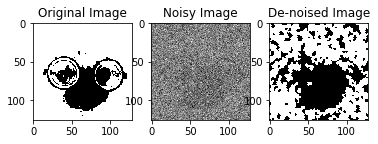

In [23]:
T = 20 # max number of iterations

#  set noise parameters
noise = [1.0, 3.2, 1] # [prop, varSigma, level]

# set energy function constants
consts = [0.3, 0.5, 1.5] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run variational Bayes
varBayes('pug-glasses.jpg',noise,consts,plot_all_flag=0)

### Variational Bayes on a noisy image with 50% of pixels affected by Gaussian Noise with variance 3.2

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  50.01 %
Iteration:  1
Percent of pixels correct:  84.0 %
Iteration:  2
Percent of pixels correct:  93.7 %
Iteration:  3
Percent of pixels correct:  94.7 %
Iteration:  4
Percent of pixels correct:  94.82 %
Iteration:  5
Percent of pixels correct:  94.93 %
Iteration:  6
Percent of pixels correct:  95.0 %
Iteration:  7
Percent of pixels correct:  95.05 %
Iteration:  8
Percent of pixels correct:  95.05 %
Iteration:  9
Percent of pixels correct:  95.06 %
Iteration:  10
Percent of pixels correct:  95.05 %
converged


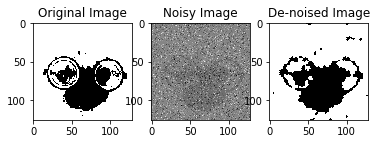

In [24]:
T = 20 # max number of iterations

#  set noise parameters
noise = [0.5, 3.2, 1] # [prop, varSigma, level]

# set energy function constants
consts = [0.3, 0.5, 1.5] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run variational Bayes
varBayes('pug-glasses.jpg',noise,consts,plot_all_flag=0)

### Variational Bayes on a noisy image with 20% of pixels affected by salt and pepper noise

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  80.0 %
Iteration:  1
Percent of pixels correct:  93.87 %
Iteration:  2
Percent of pixels correct:  96.52 %
Iteration:  3
Percent of pixels correct:  96.55 %
Iteration:  4
Percent of pixels correct:  96.46 %
Iteration:  5
Percent of pixels correct:  96.39 %
Iteration:  6
Percent of pixels correct:  96.33 %
Iteration:  7
Percent of pixels correct:  96.29 %
Iteration:  8
Percent of pixels correct:  96.24 %
Iteration:  9
Percent of pixels correct:  96.24 %
Iteration:  10
Percent of pixels correct:  96.23 %
Iteration:  11
Percent of pixels correct:  96.22 %
Iteration:  12
Percent of pixels correct:  96.2 %
Iteration:  13
Percent of pixels correct:  96.17 %
Iteration:  14
Percent of pixels correct:  96.16 %
Iteration:  15
Percent of pixels correct:  96.14 %
Iteration:  16
Percent of pixels correct:  96.13 %
Iteration:  17
Percent of pixels correct:  96.11 %
Iteration:  18
Percent of pixels correct:  96.11 %
Iteration:  19
Percent of pixels correct:  96.11 %
Iterat

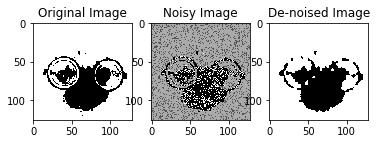

In [25]:
T = 20 # max number of iterations

#  set noise parameters
noise = [0.2, 0, 2] # [prop, varSigma, level]

# set energy function constants
consts = [0.3, 0.5, 1.5] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run variational Bayes
varBayes('pug-glasses.jpg',noise,consts,plot_all_flag=0)

### Variational Bayes on a noisy image with 50% of pixels affected by salt and pepper noise

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Percent of pixels correct:  50.01 %
Iteration:  1
Percent of pixels correct:  86.32 %
Iteration:  2
Percent of pixels correct:  85.17 %
Iteration:  3
Percent of pixels correct:  85.29 %
Iteration:  4
Percent of pixels correct:  85.42 %
Iteration:  5
Percent of pixels correct:  85.5 %
Iteration:  6
Percent of pixels correct:  85.53 %
Iteration:  7
Percent of pixels correct:  85.62 %
Iteration:  8
Percent of pixels correct:  85.73 %
Iteration:  9
Percent of pixels correct:  85.81 %
Iteration:  10
Percent of pixels correct:  85.91 %
Iteration:  11
Percent of pixels correct:  85.96 %
Iteration:  12
Percent of pixels correct:  85.99 %
Iteration:  13
Percent of pixels correct:  86.03 %
Iteration:  14
Percent of pixels correct:  86.04 %
Iteration:  15
Percent of pixels correct:  86.09 %
Iteration:  16
Percent of pixels correct:  86.1 %
Iteration:  17
Percent of pixels correct:  86.11 %
Iteration:  18
Percent of pixels correct:  86.12 %
Iteration:  19
Percent of pixels correct:  86.13 %
conver

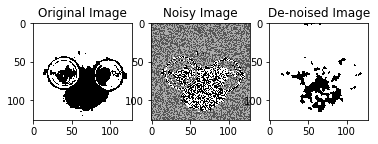

In [26]:
T = 20 # max number of iterations

#  set noise parameters
noise = [0.5, 0, 2] # [prop, varSigma, level]

# set energy function constants
consts = [0.3, 0.5, 1.5] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# run variational Bayes
varBayes('pug-glasses.jpg',noise,consts,plot_all_flag=0)

## Question 7 - How does the result of the Variational Bayes method compare to the two previous approaches?

The variational Bayes method is much faster than both of the other methods and also appears to de-noise the image much better than they do.

how does it handle different types of noise

## Question 8 - Variational Bayes image segmentation

In [27]:
def varBayesImageSeg(noisyImg,latentImg,x,y,consts,mu,histF,histB):
    ########################################################################################
    # varBayes -> Calculates best value of pixel for current state using variational Bayes
    #               and updates variational parameter
    #   Inputs:
    #       noisyImg -> noisy image
    #       latentImg -> latent image
    #       x -> x position
    #       y -> y position
    #       consts -> energy function constants [h,beta,n]
    #       mu -> variational parameter
    #       histF -> foreground histogram
    #       histB -> background histogram
    #   Outputs:
    #       latentImg -> latent image with preferred pixel value
    #       mu -> variational parameter
    ########################################################################################
    # calculate average value for pixel i
    val = noisyImg[x, y]
    val = sum(val) / 3

    # set histogram values
    nB, binsB, patchesB = histB
    nF, binsF, patchesF = histF

    # find likelihood of foregrounf and background and normalise
    likelihoodF = nF[int(round(val))]
    likelihoodB = nB[int(round(val))]
    sumLikelihood = likelihoodB + likelihoodF
    likelihoodF = likelihoodF / sumLikelihood
    likelihoodB = likelihoodB / sumLikelihood

    # calculate variational parameter for current pixel
    m_i = 0
    neighbour = neighbours(x, y, latentImg.shape[0], latentImg.shape[1], size=8)
    for ii in range(len(neighbour)):
        neighbour1 = neighbour[ii]
        m_i += consts[1] * mu[neighbour1[0], neighbour1[1]]
    a_i = m_i + (likelihoodF - likelihoodB) # where Li(xi) = h*sumXi - n*sumXiYi
    mu_i = np.tanh(a_i)

    # update variational parameter matrix
    mu[x, y] = mu_i

    # calculate posterior for pixel i
    q_x = 1 / (1 + np.exp(-2 * a_i))

    # set pixel value in latent image (x) based on posterior
    if q_x < 0.5:
        latentImg[x, y] = 1
    else:
        latentImg[x, y] = -1

    return latentImg, mu

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5


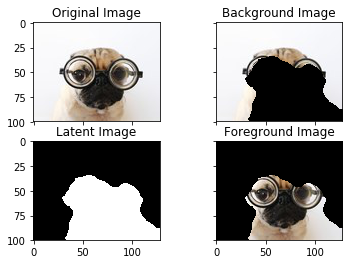

In [28]:
T = 5 # number of iterations

# set energy function constants
consts = [1, 0.5, 1] #[h, beta, n], [bias constant, xixj energy constant, xiyi energy constant]

# read image and set latent and input images
orgImg = imread('pugRGBsmall.jpg') # original image
yImg = np.array(orgImg) # input image
xImg = np.zeros([orgImg.shape[0],orgImg.shape[1]]) # latent image
orgImg1 = np.zeros([orgImg.shape[0],orgImg.shape[1]]) # input image averaged RGB
orgImg1 = (orgImg[:,:,0] + orgImg[:,:,1] + orgImg[:,:,2])/3 # input image averaged RGB
xImg[orgImg1<np.mean(orgImg1)] = -1 # background
xImg[orgImg1>=np.mean(orgImg1)] = 1 # foreground

# set variational distribution
mu = np.zeros([xImg.shape[0], xImg.shape[1]])

for i in range(T):
    # find foreground and background histograms (normalised)
    histF = plt.hist(yImg[xImg == 1].ravel(), bins=256, range=(0, 256), normed='True')
    histB = plt.hist(yImg[xImg == -1].ravel(), bins=256, range=(0, 256), normed='True')
    # plt.show()
    for x in range(xImg.shape[0]):
        for y in range(xImg.shape[1]):

            xImg, mu = varBayesImageSeg(yImg, xImg, x, y, consts, mu, histF, histB)

    print("Iteration: ", i + 1)

# Create foreground/background masks
maskF = np.copy(yImg)
maskB = np.copy(yImg)
maskF[xImg == -1] = 0
maskB[xImg == 1] = 0

# Plot original image, latent image, foreground mask and background mask
plt.close()
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(orgImg,cmap='gray')
axarr[0, 0].set_title('Original Image')
axarr[1, 0].imshow(xImg,cmap='gray')
axarr[1, 0].set_title('Latent Image')
axarr[0, 1].imshow(maskB,cmap='gray')
axarr[0, 1].set_title('Background Image')
axarr[1, 1].imshow(maskF,cmap='gray')
axarr[1, 1].set_title('Foreground Image')
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False) # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
plt.show()